# Projet numérique de Science des Données 2025

__Binôme numéro 31 - MARTINEZ Adrien et MAZELIER Côme__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

**Réponse**

Un algorithme de prédiction du risque obstétrique permettrait de pouvoir traiter en priorité les grossesses à risque, et donc rendre plus efficace l'accès aux soins. En mettant à la disposition des habitants les outils pour mesurer les grandeurs demandées par l'algorithme en entrée, on pourrait procéder à un premier diagnostic avant d'avoir à appeler un médecin en cas de risque élevé. 

On peut imaginer des dérives poussant par exemple les femmes présentant des grossesses à risque à avorter suivant le résultat de l'algorithme, ou bien encore donner une consultation en priorité à une personne à risque, au détriment d'une autre moins à risque mais qui la nécessiterait tout autant. 

## Librairies usuelles

In [1]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [2]:
df_train = pd.read_csv('data/donnees_entrainement.csv')

In [3]:
df_train.describe()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,29.328750,113.38125,76.725000,8.729750,37.079250,74.633750,0.871250
std,11.919869,18.62544,13.982803,3.261953,0.804785,7.845161,0.803418
min,11.500000,65.00000,40.000000,5.900000,36.200000,59.000000,0.000000
25%,20.000000,95.00000,65.000000,6.900000,36.500000,69.000000,0.000000
50%,25.750000,120.00000,80.000000,7.500000,36.900000,75.000000,1.000000
75%,36.000000,125.00000,90.000000,8.025000,37.400000,80.000000,2.000000
max,57.500000,165.00000,105.000000,19.200000,39.500000,91.000000,2.000000


Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [4]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

In [5]:
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]

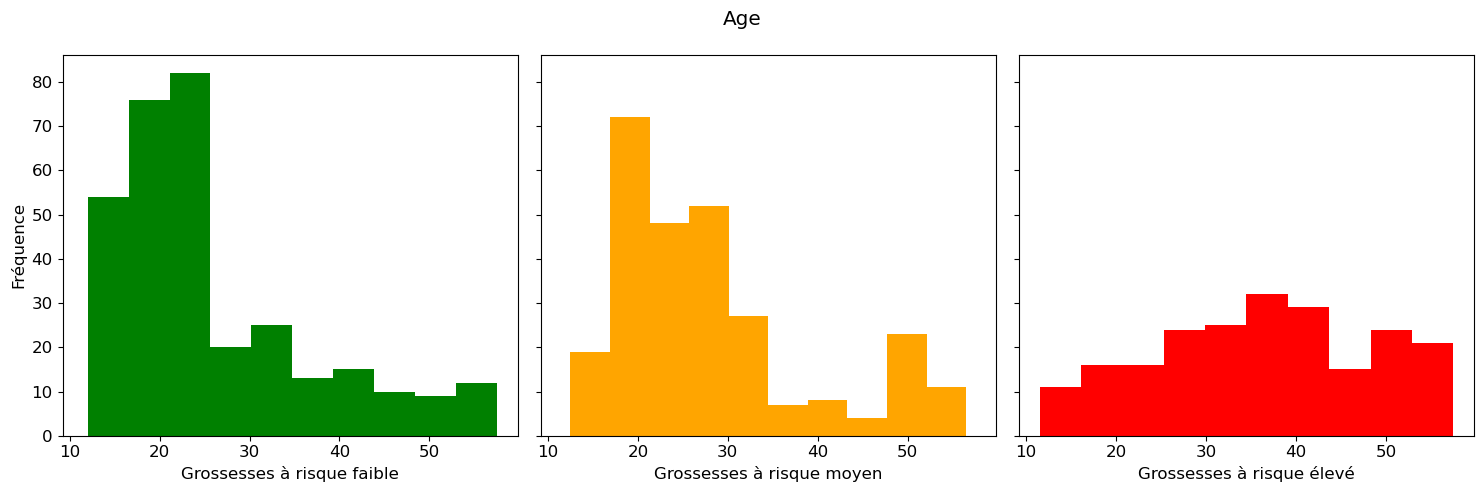

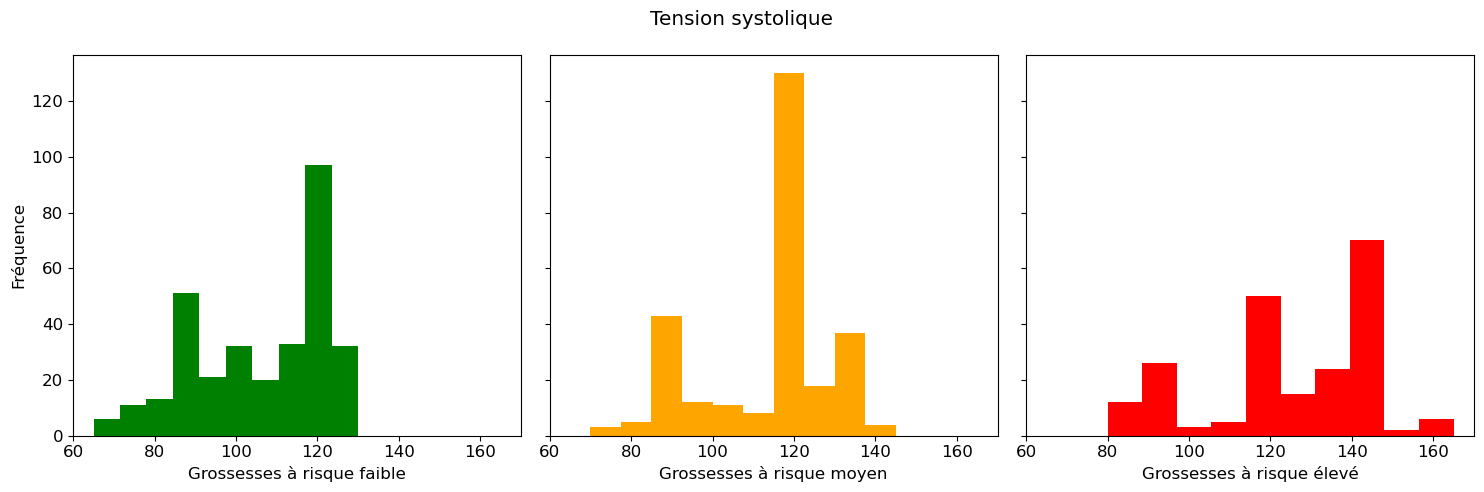

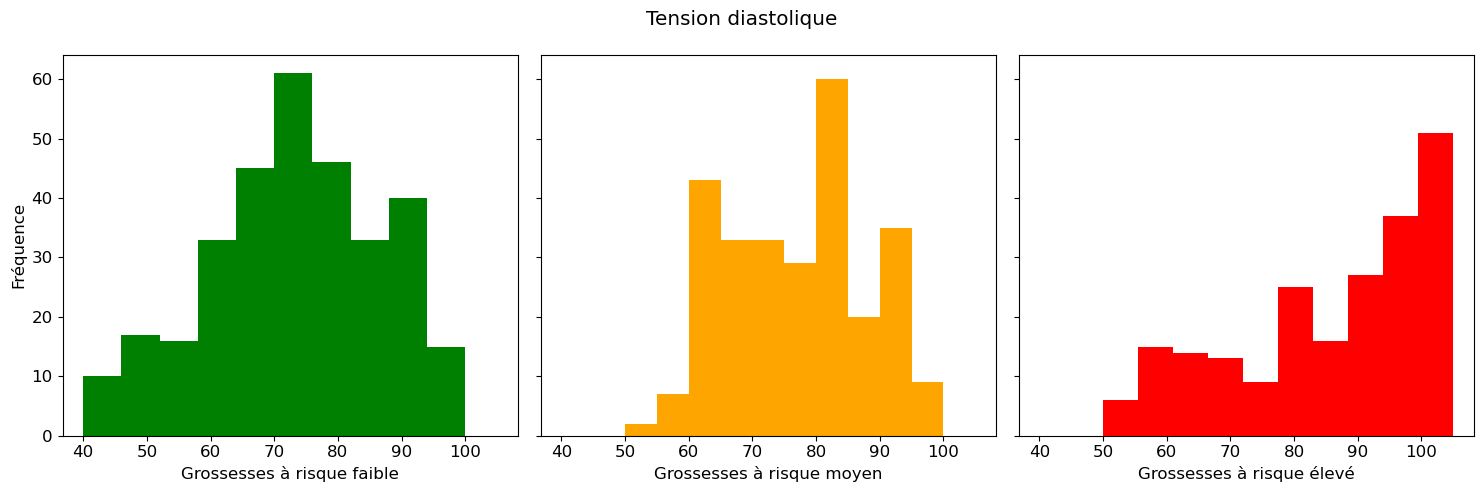

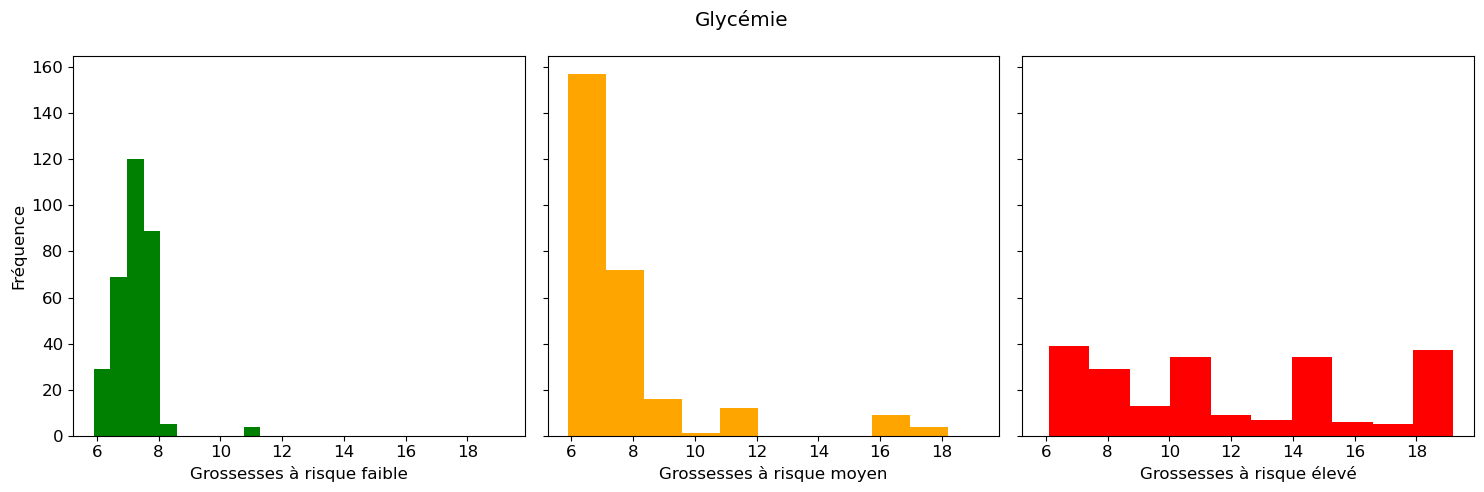

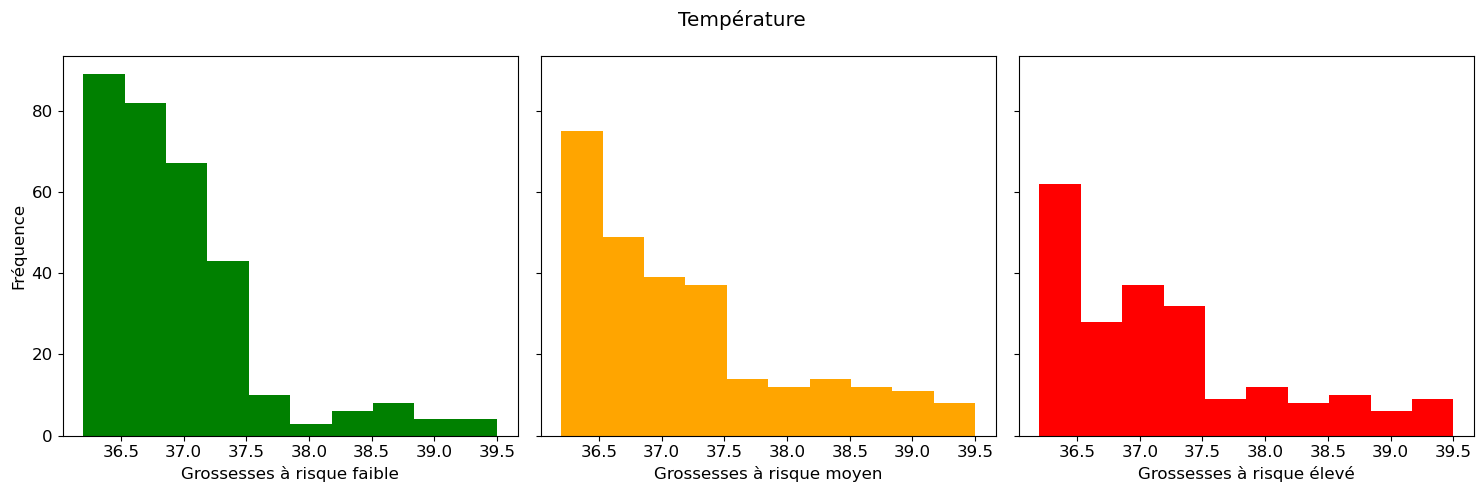

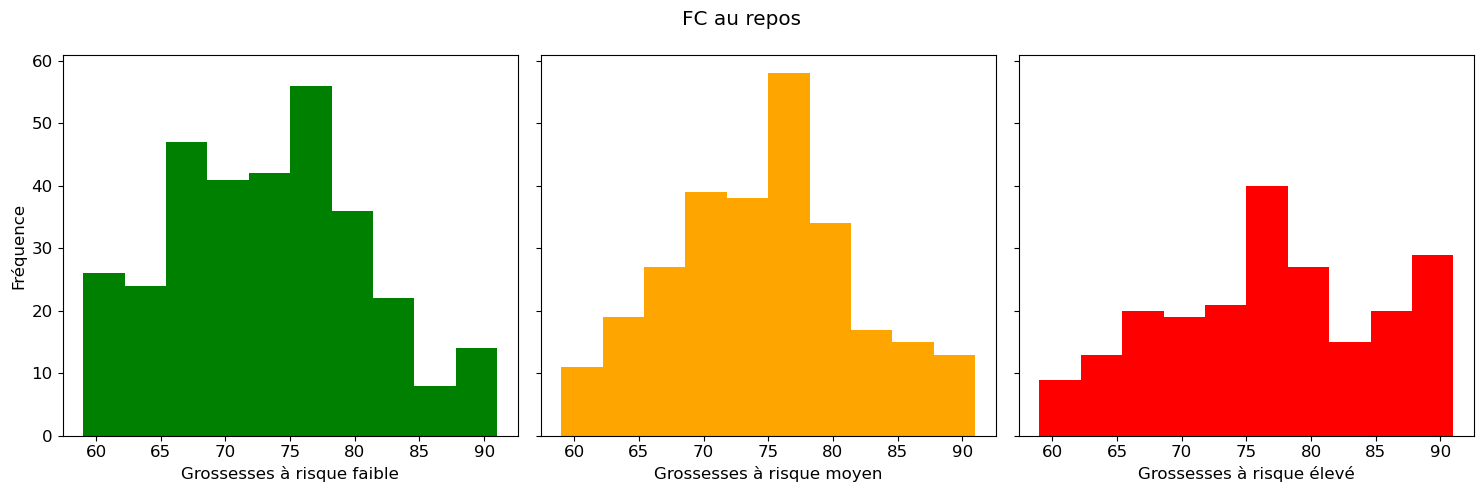

In [6]:
for i in range(X_train.shape[1]):
    fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)

    ax[0].hist(X_train_0[:,i], color='green')
    ax[0].set_xlabel('Grossesses à risque faible')
    ax[0].set_ylabel('Fréquence')

    ax[1].hist(X_train_1[:,i], color='orange')
    ax[1].set_xlabel('Grossesses à risque moyen')
    

    ax[2].hist(X_train_2[:,i], color='red')
    ax[2].set_xlabel('Grossesses à risque élevé')
    
    
    fig.suptitle(df_train.columns[i])
    plt.tight_layout()
    plt.show()


### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

**Réponse**

On remarque tout d'abord que la distribution des âges parmi les grossesses à risque est bien plus marquée que celle des grossesses à faible risque (où les fréquences les plus élévées correspondent aux âges jeunes). Ceci est cohérent avec la dégradation de la santé avec l'âge. 

On observe aussi une tension systolique maximale plus élevée chez les grossesses à risque, et une tension diastolique largement concentrée sur la valeur maximale des deux autres catégories de grossesses. 

Enfin, la glycémie chez les personnes à risque est généralement plus élevée, tandis que la température corporelle ne semble pas jouer de rôle prépondérant. La fréquence cardiaque maximale a tendance à être plus élevée chez les individus à risque. 

Toutes ces observations semblent cohérentes avec une grossesse à risque, notamment pour l'hypertension et l'âge plus élevé.

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

**Réponse**

Les distributions de ces variables suivant leur étiquette de risque semblent suffisamment différentes pour pouvoir permettre une prédiction facile du risque de grossesse, mais il est probable que la température corporelle ne joue pas de rôle prépondérant dans le processus.

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

Text(0, 0.5, 'PC 2')

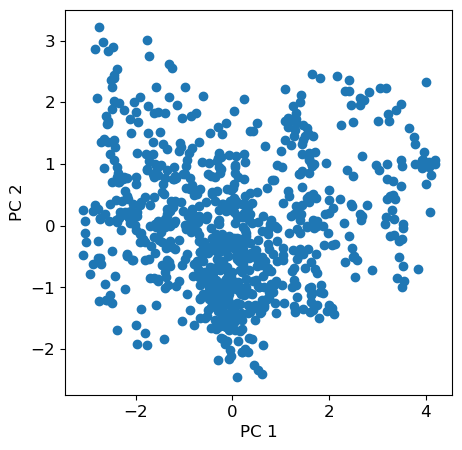

In [8]:
# La question ne précise pas si on peut faire appel au module sklearn, 
# mais puisque celui-ci est utilisé dans la suite du sujet, on l'utilise aussi ici.
# On aurait pu toutefois calculer l'ACP de X_train à l'aide de la SVD de X_train, 
# mais cela reste plus fastidieux. 
# On reproduit la démarche réalisée à la PC3, et on centre et réduit les données.
from sklearn import preprocessing
from sklearn import decomposition

std_scale = preprocessing.StandardScaler().fit(X_train)
X_scaled = std_scale.transform(X_train)

pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)

fig = plt.figure(figsize=(5, 5))

plt.scatter(X_projected[:, 0], X_projected[:, 1])

plt.xlabel("PC 1")
plt.ylabel("PC 2")

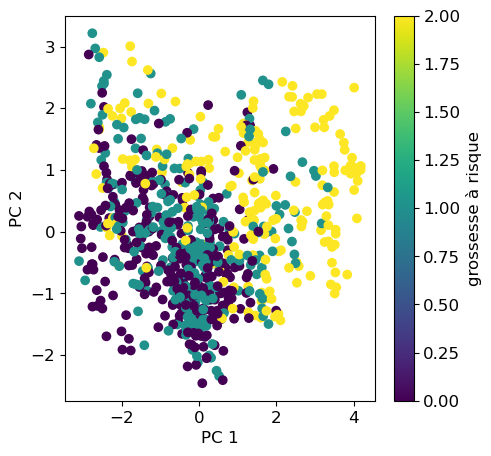

In [9]:
# On relie ici chaque point au niveau de risque de grossesse à complications qui lui est associé.
fig = plt.figure(figsize=(5, 5))

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y_train)

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='grossesse à risque')

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

**Réponse**

Cette ACP ne semble pas faire de distinction entre risque 0 et risque 1, ce qui ne permettra a priori pas de faire un prédicteur de risque de grossesse difficile fiable.

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

<Axes: >

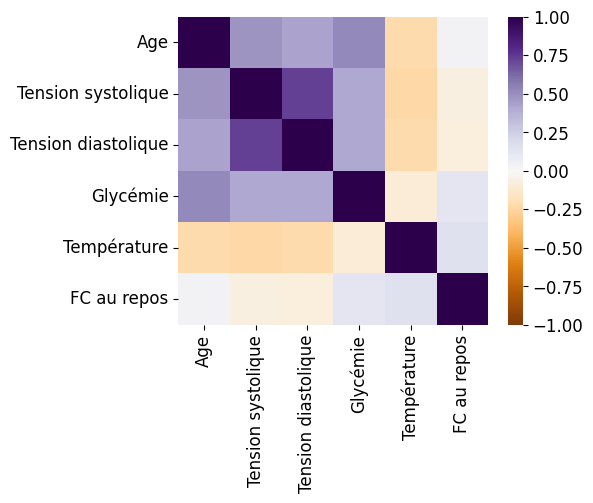

In [10]:
matrice_corr = df_train.drop(columns=['Risque']).corr()

import seaborn as sns
plt.figure(figsize=(5, 4))
sns.heatmap(matrice_corr, vmin=-1, vmax=1, center= 0, cmap='PuOr')

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

**Réponse**

On sélectionne une variable par "groupe" de corrélation : on choisira en priorité ainsi une des deux tensions diastoliques ou systoliques, la fréquence cardiaque au repos, la température. La faible covariance de ces grandeurs assure que chaque variable apporte de l'information nouvelle.

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [10]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler

kf = model_selection.KFold(n_splits=10, shuffle=True)

In [13]:
param_C_l1 = np.logspace(-3, -1, 40) # les hyperparamètres que l'on va tester
logistic_regression_l1 = LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear')
grid_l1 = model_selection.GridSearchCV(logistic_regression_l1, {'C': param_C_l1}, cv=kf, scoring=make_scorer(balanced_accuracy_score)) 
# Après recherche sur internet, il faut utiliser make_scorer pour pouvoir utiliser GridSearchCV avec balanced_accuracy_score

grid_l1.fit(X_scaled, y_train_risk_vs_norisk)
# On utilise X_scaled car la régularisation est sensible à la taille des valeurs

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(max_iter=10000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.001     , 0.00112534, 0.00126638, 0.0014251 , 0.00160372,
       0.00180472, 0.00203092, 0.00228546, 0.00257191, 0.00289427,
       0.00325702, 0.00366524, 0.00412463, 0.00464159, 0.00522335,
       0.00587802, 0.00661474, 0.0074438 , 0.00837678, 0.00942668,
       0.01060818, 0.01193777, 0.01343399, 0.01511775, 0.01701254,
       0.01914482, 0.02154435, 0.02424462, 0.02728333, 0.03070291,
       0.03455107, 0.03888155, 0.04375479, 0.04923883, 0.0554102 ,
       0.06235507, 0.07017038, 0.07896523, 0.08886238, 0.1       ])},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'))

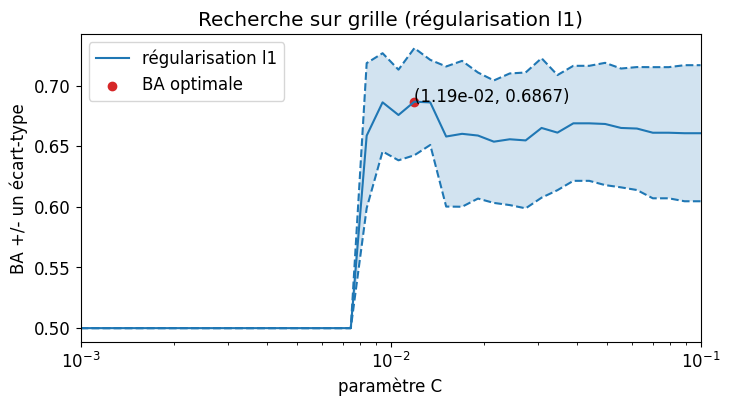

In [14]:
# On s'inspire ici du TD 6
plt.figure(figsize=(8, 4))

BAs_l1 = grid_l1.cv_results_['mean_test_score']
std_error = grid_l1.cv_results_['std_test_score']

# afficher les BA avec une échelle logarithmique pour les abscisses :
plt.semilogx(param_C_l1, BAs_l1, label="régularisation l1", color='tab:blue')
plt.semilogx(param_C_l1, BAs_l1 + std_error, color='tab:blue', linestyle='dashed')
plt.semilogx(param_C_l1, BAs_l1 - std_error, color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(param_C_l1, (BAs_l1 + std_error), (BAs_l1 - std_error), 
                 alpha=0.2 # contrôle la transparence
                )

# afficher le meilleur score
plt.scatter(grid_l1.best_params_['C'], grid_l1.best_score_, 
           color='tab:red', label='BA optimale')
# pour afficher les coordonnées et pouvoir comparer les régularisations offrant des résultats similaires
plt.text(grid_l1.best_params_['C'], grid_l1.best_score_, f"({grid_l1.best_params_['C']:.2e}, {grid_l1.best_score_:.4f})")

# Mise en forme
plt.xlabel("paramètre C")
plt.ylabel("BA +/- un écart-type")
plt.xlim([param_C_l1[0], param_C_l1[-1]])
plt.title("Recherche sur grille (régularisation l1)")
plt.legend(loc='best')

In [15]:
param_C_l2 = np.logspace(-3, -1, 40) # les hyperparamètres que l'on va tester
logistic_regression_l2 = LogisticRegression(max_iter=10000, penalty='l2', solver='liblinear')
grid_l2 = model_selection.GridSearchCV(logistic_regression_l2, {'C': param_C_l2}, cv=kf, scoring=make_scorer(balanced_accuracy_score))

grid_l2.fit(X_scaled, y_train_risk_vs_norisk)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             param_grid={'C': array([0.001     , 0.00112534, 0.00126638, 0.0014251 , 0.00160372,
       0.00180472, 0.00203092, 0.00228546, 0.00257191, 0.00289427,
       0.00325702, 0.00366524, 0.00412463, 0.00464159, 0.00522335,
       0.00587802, 0.00661474, 0.0074438 , 0.00837678, 0.00942668,
       0.01060818, 0.01193777, 0.01343399, 0.01511775, 0.01701254,
       0.01914482, 0.02154435, 0.02424462, 0.02728333, 0.03070291,
       0.03455107, 0.03888155, 0.04375479, 0.04923883, 0.0554102 ,
       0.06235507, 0.07017038, 0.07896523, 0.08886238, 0.1       ])},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'))

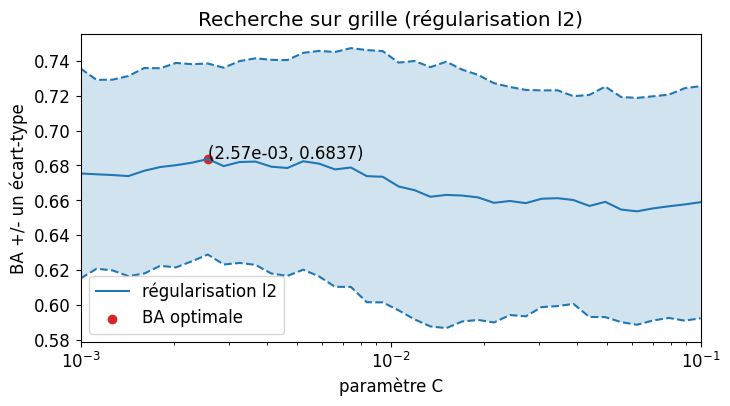

In [16]:
plt.figure(figsize=(8, 4))

BAs_l2 = grid_l2.cv_results_['mean_test_score']
std_error = grid_l2.cv_results_['std_test_score']

plt.semilogx(param_C_l2, BAs_l2, label="régularisation l2", color='tab:blue')
plt.semilogx(param_C_l2, BAs_l2 + std_error, color='tab:blue', linestyle='dashed')
plt.semilogx(param_C_l2, BAs_l2 - std_error, color='tab:blue', linestyle='dashed')

plt.fill_between(param_C_l2, (BAs_l2 + std_error), (BAs_l2 - std_error), 
                 alpha=0.2 # contrôle la transparence
                )

plt.scatter(grid_l2.best_params_['C'], grid_l2.best_score_, 
           color='tab:red', label='BA optimale')

plt.text(grid_l2.best_params_['C'], grid_l2.best_score_, f"({grid_l2.best_params_['C']:.2e}, {grid_l2.best_score_:.4f})")

plt.xlabel("paramètre C")
plt.ylabel("BA +/- un écart-type")
plt.xlim([param_C_l2[0], param_C_l2[-1]])
plt.title("Recherche sur grille (régularisation l2)")
plt.legend(loc='best')

In [17]:
l1_ratio_elastic = np.logspace(-6, 0, 40) # les hyperparamètres que l'on va tester
logistic_regression_elastic = LogisticRegression(max_iter=10000, penalty='elasticnet', solver='saga')
grid_elastic = model_selection.GridSearchCV(logistic_regression_elastic, {'l1_ratio': l1_ratio_elastic}, cv=kf, scoring=make_scorer(balanced_accuracy_score))

grid_elastic.fit(X_scaled, y_train_risk_vs_norisk)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(max_iter=10000, penalty='elasticnet',
                                          solver='saga'),
             param_grid={'l1_ratio': array([1.00000000e-06, 1.42510267e-06, 2.03091762e-06, 2.89426612e-06,
       4.12462638e-06, 5.87801607e-06, 8.37677640e-06, 1.19377664e-05,
       1.70125428e-05, 2.42446202e-05, 3.45510729e-05, 4.9238826...
       1.19377664e-03, 1.70125428e-03, 2.42446202e-03, 3.45510729e-03,
       4.92388263e-03, 7.01703829e-03, 1.00000000e-02, 1.42510267e-02,
       2.03091762e-02, 2.89426612e-02, 4.12462638e-02, 5.87801607e-02,
       8.37677640e-02, 1.19377664e-01, 1.70125428e-01, 2.42446202e-01,
       3.45510729e-01, 4.92388263e-01, 7.01703829e-01, 1.00000000e+00])},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'))

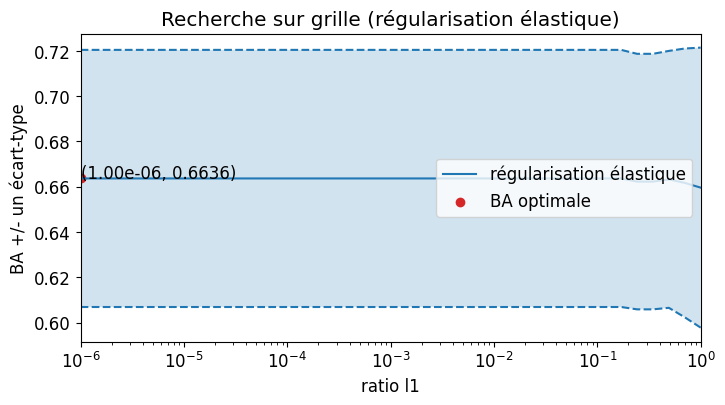

In [18]:
plt.figure(figsize=(8, 4))

BAs_elastique = grid_elastic.cv_results_['mean_test_score']
std_error = grid_elastic.cv_results_['std_test_score']

plt.semilogx(l1_ratio_elastic, BAs_elastique, label="régularisation élastique", color='tab:blue')
plt.semilogx(l1_ratio_elastic, BAs_elastique + std_error, color='tab:blue', linestyle='dashed')
plt.semilogx(l1_ratio_elastic, BAs_elastique - std_error, color='tab:blue', linestyle='dashed')

plt.fill_between(l1_ratio_elastic, (BAs_elastique + std_error), (BAs_elastique - std_error), 
                 alpha=0.2 # contrôle la transparence
                )

plt.scatter(grid_elastic.best_params_['l1_ratio'], grid_elastic.best_score_, 
           color='tab:red', label='BA optimale')
plt.text(grid_elastic.best_params_['l1_ratio'], grid_elastic.best_score_, f"({grid_elastic.best_params_['l1_ratio']:.2e}, {grid_elastic.best_score_:.4f})")

plt.xlabel("ratio l1")
plt.ylabel("BA +/- un écart-type")
plt.xlim([l1_ratio_elastic[0], l1_ratio_elastic[-1]])
plt.title("Recherche sur grille (régularisation élastique)")
plt.legend(loc='best')

In [35]:
print(f"Les meilleurs paramètres sont {grid_l1.best_params_} avec une balanced accuracy de {grid_l1.best_score_}")

Les meilleurs paramètres sont {'C': np.float64(0.011937766417144363)} avec une balanced accuracy de 0.6867226591786139


**Réponse**

Il faudrait a priori utiliser la régularisation $l1$, avec un paramètre $C$ affiché directement sur le graphique ($1,19 \times 10^{-2}$ le plus souvent) correspondant pour obtenir la meilleure balanced accuracy possible, qui a pour valeur environ $$BA \approx 0,69$$ On remarque cependant que cette dernière est sensible au solveur utilisé (on a de meilleurs résultats lorsqu'on utilise liblinear pour les régularisations $l1$ et $l2$), et qu'on ne peut pas à la fois avoir le solveur optimal pour les 3 régularisations.

D'autre part, une balanced accuracy de $0,69$ n'est pas un score très élevé, ce n'est pas beaucoup mieux que de prédire au hasard l'étiquette ($BA = 0,5$). Peut-être qu'il faut réaliser une réduction de dimension pour obtenir de meilleures performances.

Les grilles de valeurs ont été déterminées de manière heuristique : d'abord, on couvre la plus grande étendue (typiquement de $10^{-8}$ à $10^8$ pour l'hyperparamètre dans les cas $l1$ et $l2$, $10^{-8}$ à $1$ pour le cas élastique) avec un nombre réduit de valeurs, pour se faire une idée de là où se trouve le meilleur paramètre. On observe que celui-ci se trouve dans la plage $10^{-3}$ à $10^{-1}$, que l'on analyse en profondeur.

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

On décide de travailler avec une machine à vecteur support de noyau, ce noyau étant la Radial Basis Function (RBF), qui fait intervenir deux paramètres, $\gamma$ et $C$, $\gamma$ étant propre au noyau RBF, $C$ étant commun aux méthodes à noyau et quantifie un compromis entre taille des marges et minimisation de l'erreur sur le jeu d'entraînement.


In [25]:
from sklearn.svm import SVC

C_range = np.logspace(-2, 6, 10)
gamma_range = np.logspace(-7, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = model_selection.GridSearchCV(SVC(max_iter=100000), param_grid=param_grid, cv=kf, scoring=make_scorer(balanced_accuracy_score))

grid.fit(X_scaled, y_train_risk_vs_norisk)

/Applications/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=SVC(max_iter=100000),
             param_grid={'C': array([1.00000000e-02, 7.74263683e-02, 5.99484250e-01, 4.64158883e+00,
       3.59381366e+01, 2.78255940e+02, 2.15443469e+03, 1.66810054e+04,
       1.29154967e+05, 1.00000000e+06]),
                         'gamma': array([1.00000000e-07, 7.74263683e-07, 5.99484250e-06, 4.64158883e-05,
       3.59381366e-04, 2.78255940e-03, 2.15443469e-02, 1.66810054e-01,
       1.29154967e+00, 1.00000000e+01])},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'))

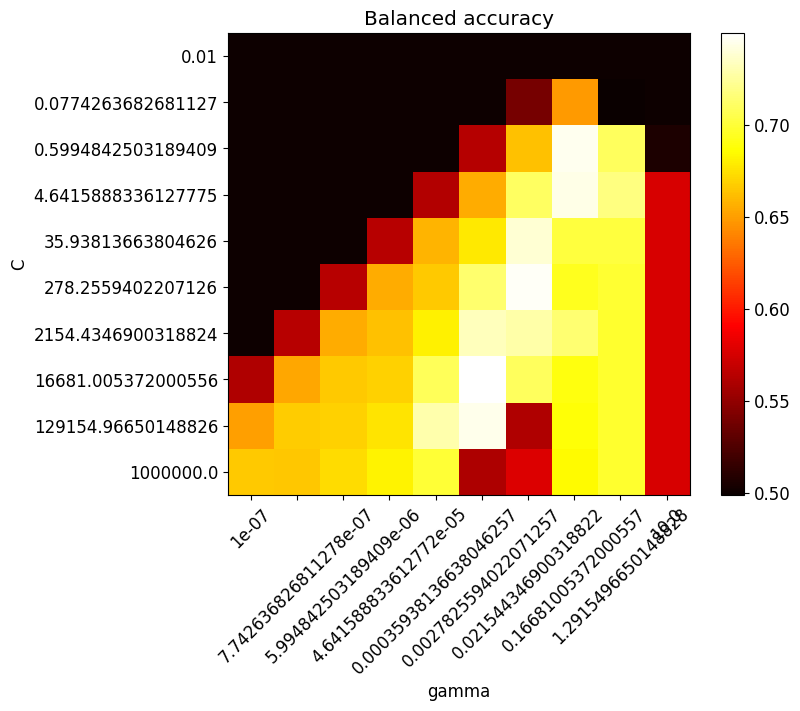

In [37]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))
plt.figure(figsize=(8, 6))

plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Balanced accuracy")
plt.show()

In [42]:
print(f"Les meilleurs paramètres sont \n{grid.best_params_} \navec une balanced accuracy de {grid.best_score_}")

Les meilleurs paramètres sont 
{'C': np.float64(16681.005372000556), 'gamma': np.float64(0.0027825594022071257)} 
avec une balanced accuracy de 0.749885653670617


**Plusieurs remarques :**

Le modèle ne converge pas si on ne fixe pas un nombre d'itérations, ce qui signifie que les scores annoncés sont sous-estimés par rapport à la réalité. Scikit recommande de travailler avec des valeurs centrées-réduites ou entre 0 et 1. Mais nous utilisons des valeurs centrées-réduites pour X_scaled, pas pour chaque fold. Après quelques recherches, il se trouve qu'il faudrait utiliser une **pipeline** pour réaliser ce prétraitement des valeurs à chaque fold. En l'état, l'utilisation de X_scaled interfère avec les prédictions du modèle.

Pour déterminer les valeurs d'intérêt, on a d'abord fait un test d'hyperparamètres avec de larges étendues, avant de sélectionner des intervalles où les prédictions sont les plus précises.

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

Text(0.5, 1.0, 'Proportion cumulative de variance expliquée')

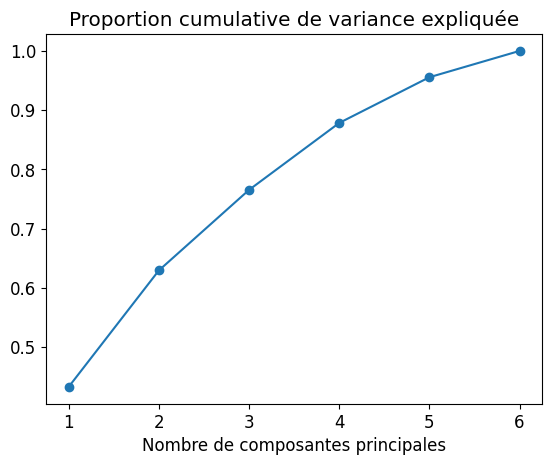

In [47]:
pca_test = decomposition.PCA(n_components=6)
pca_test.fit(X_scaled)
np.cumsum(pca_test.explained_variance_ratio_)

plt.plot(np.arange(1, 7), np.cumsum(pca_test.explained_variance_ratio_), marker='o')

plt.xlabel("Nombre de composantes principales")
plt.title("Proportion cumulative de variance expliquée")

Il faut donc utiliser une décomposition à 4 composantes principales pour expliquer 80% de la variance des données.

In [49]:
pca_finale = decomposition.PCA(n_components=4)
X_transformed = pca_finale.fit_transform(X_scaled)
print(X_transformed.shape)

(800, 4)


### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.